## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

This notebook uses BERT for this task. Other approaches can be found in sentence_quality_classifier.ipynb

In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import numpy as np

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality-8k.csv",
    "seq_len": 128,
    "batch_size": 128,
    "epochs": 8,
    "lr": 1e-1,
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier-bert.json"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [34]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

Number of sentences: 8007
Number of sentences with label: 8005


['LOW_QUALITY', 'SENTENCE', 'REFERENCE', 'TITLE', 'FOREIGN']

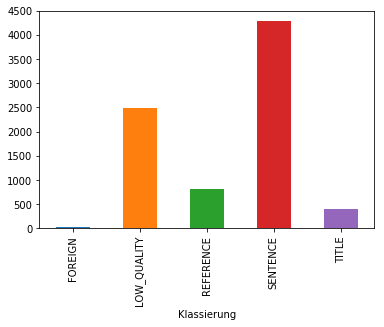

In [35]:
# set targets
print("Number of sentences: " + str(len(data.index)))
data = data.dropna(subset= ['Klassierung'])
print("Number of sentences with label: " + str(len(data.index)))
data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()
classes

In [36]:
# Load pretrained BERT model
from keras_bert import Tokenizer
import keras
from keras_bert import get_base_dict, get_model, gen_batch_inputs
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths
import codecs
from keras_bert import load_trained_model_from_checkpoint
import os

## Multilingueal pretrained by Google
# model_path = get_pretrained(PretrainedList.multi_cased_base)
# paths = get_checkpoint_paths(model_path)
# print(paths.config, paths.checkpoint, paths.vocab)

# German only pretrained by Deepset
pretrained_path = '/home/tim/medtextcollector/data/bert-base-german-cased'
class Paths(object):
    pass
paths = Paths()
paths.config = os.path.join(pretrained_path, 'bert_config.json')
paths.checkpoint = os.path.join(pretrained_path, 'bert-base-german-cased')
paths.vocab = os.path.join(pretrained_path, 'vocab.txt')

token_dict = get_base_dict()  # A dict that contains some special tokens
with codecs.open(paths.vocab, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        
print("Vocabulary size: " + str(len(token_dict)))

model = load_trained_model_from_checkpoint(
    paths.config,
    paths.checkpoint,
    training=True,
    trainable=False,
    seq_len=config["seq_len"],
)

Vocabulary size: 30000


In [37]:
model.summary()
model_plot_src = os.path.join('bert_model.png')
from keras.utils import plot_model
plot_model(model, to_file=model_plot_src, show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23040000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [38]:
# Convert data
tokenizer = Tokenizer(token_dict)

indices = []
for sentence in data["Satz"]:
    ids, segments = tokenizer.encode(sentence, max_len=config["seq_len"])
    indices.append(ids)
indices = np.array(indices)
target_indices = np.array([classes.index(target) for target in data["label"]])

#train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(indices, target_indices, random_state = 2)

# input is an array of the token indices and an array of the segment indices
# (which is 0 for all tokens in this task)
segments_test = np.zeros_like(X_test)
segments_train = np.zeros_like(X_train)

In [39]:
tokenizer.tokenize("Der Patient hat Anzeichen von sdf.")

['[CLS]',
 'der',
 'pat',
 '##ient',
 'hat',
 'an',
 '##zeichen',
 'von',
 's',
 '##d',
 '##f',
 '.',
 '[SEP]']

In [49]:
# Build Custom Model / Add softmax layer for sentence classification on top
import keras
from keras_bert import AdamWarmup, calc_train_steps
import keras_bert

inputs = model.inputs[:2]

encoder = model.get_layer('Encoder-2-FeedForward-Norm').output
# remove_masking = Lambda(lambda x: x, output_shape=lambda s:s)(encoder)
extract = keras.layers.LSTM(units=768, recurrent_dropout=0.4, return_sequences=False)(encoder)
#extract = keras_bert.layers.Extract(index=0)(encoder)
# dense = model.get_layer('NSP-Dense').output
dense = keras.layers.Dense(units=64, activation='relu')(extract)
outputs = keras.layers.Dense(units=len(classes), activation='softmax')(dense)

decay_steps, warmup_steps = calc_train_steps(
    y_train.shape[0],
    batch_size=config["batch_size"],
    epochs=config["epochs"],
)

custom_model = keras.models.Model(inputs, outputs)
custom_model.compile(
    #AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=config["lr"]),
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)


In [50]:
custom_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23040000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [51]:
custom_model.fit(
    x=[X_train, segments_train],
    y=y_train,
    validation_data=[[X_test, segments_test], y_test],
    epochs=config["epochs"],
    batch_size=config["batch_size"]
)

Train on 6003 samples, validate on 2002 samples
Epoch 1/8
6003/6003 [==============================] - 25s 4ms/step - loss: 0.8994 - sparse_categorical_accuracy: 0.6393 - val_loss: 0.7743 - val_sparse_categorical_accuracy: 0.7268
Epoch 2/8
6003/6003 [==============================] - 22s 4ms/step - loss: 0.6786 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.6311 - val_sparse_categorical_accuracy: 0.7712
Epoch 3/8
6003/6003 [==============================] - 22s 4ms/step - loss: 0.5473 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.5790 - val_sparse_categorical_accuracy: 0.7772
Epoch 4/8
6003/6003 [==============================] - 22s 4ms/step - loss: 0.4576 - sparse_categorical_accuracy: 0.8243 - val_loss: 0.5582 - val_sparse_categorical_accuracy: 0.7812
Epoch 5/8
6003/6003 [==============================] - 22s 4ms/step - loss: 0.3568 - sparse_categorical_accuracy: 0.8646 - val_loss: 0.5586 - val_sparse_categorical_accuracy: 0.7862
Epoch 6/8
6003/6003 [=====================

In [52]:
predicts = custom_model.predict([X_test, segments_test], verbose=True).argmax(axis=-1)
print(np.sum(y_test == predicts) / y_test.shape[0])

2002/2002 [==============================] - 8s 4ms/step
0.8086913086913087


Text(0.5,68.0938,'Predicted')

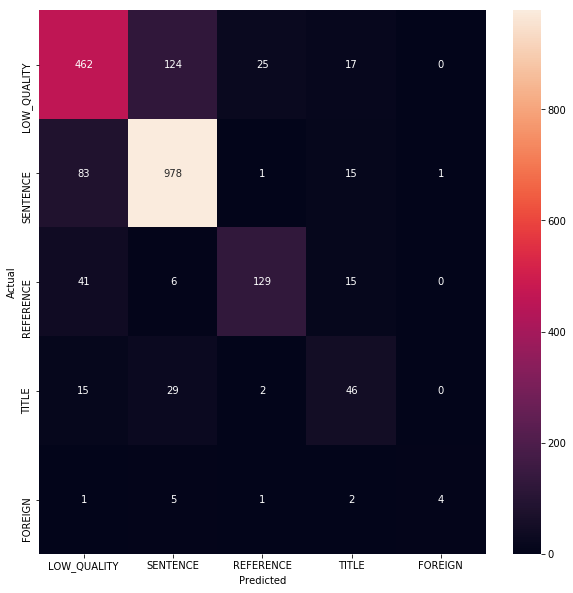

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

conf_mat = confusion_matrix(y_test, predicts)

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')